In [303]:
import numpy as np
import matplotlib.pyplot as plt

# Check NumPy version compatibility
if int(np.__version__.split('.')[0]) >= 2:
    print(f"Warning: Detected NumPy {np.__version__}, imgaug is incompatible with NumPy 2.0+")
    print("Solution: Downgrade NumPy to version 1.x")
    print("Run command: pip install 'numpy<2.0'")
    print("Or: pip install numpy==1.26.4")

import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
try:
    from imgaug import augmenters as iaa
except (ImportError, AttributeError) as e:
    if "sctypes" in str(e) or "np.sctypes" in str(e):
        print("\nError: imgaug is incompatible with NumPy 2.0+")
        print("Solution: Downgrade NumPy")
        print("Run command: pip install 'numpy<2.0'")
        print("Or: pip install numpy==1.26.4")
    else:
        print("Warning: imgaug is not installed. Please run: pip install imgaug")
    raise

import random

Found 1964 .bmp files (train: 1464, validate: 500)
Found 500 test .bmp files (test directory exists)
Data shape: x_data=(1964, 90, 90, 1), y_data=(1964, 4)
Image data type: uint8, pixel value range: [0, 255]

Test set loaded: (500, 90, 90, 1), (500, 4)

Training set: (1464, 90, 90, 1), (1464, 4)
Validation set: (500, 90, 90, 1), (500, 4)
Test set: (500, 90, 90, 1), (500, 4)

✓ Training and validation sets are separated to avoid data leakage

Data Count Summary
Training set:
  Number of images: 1464
  Number of labels: 1464
  Image shape: (90, 90, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Validation set:
  Number of images: 500
  Number of labels: 500
  Image shape: (90, 90, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Total dataset:
  Total images: 1964
  Total labels: 1964


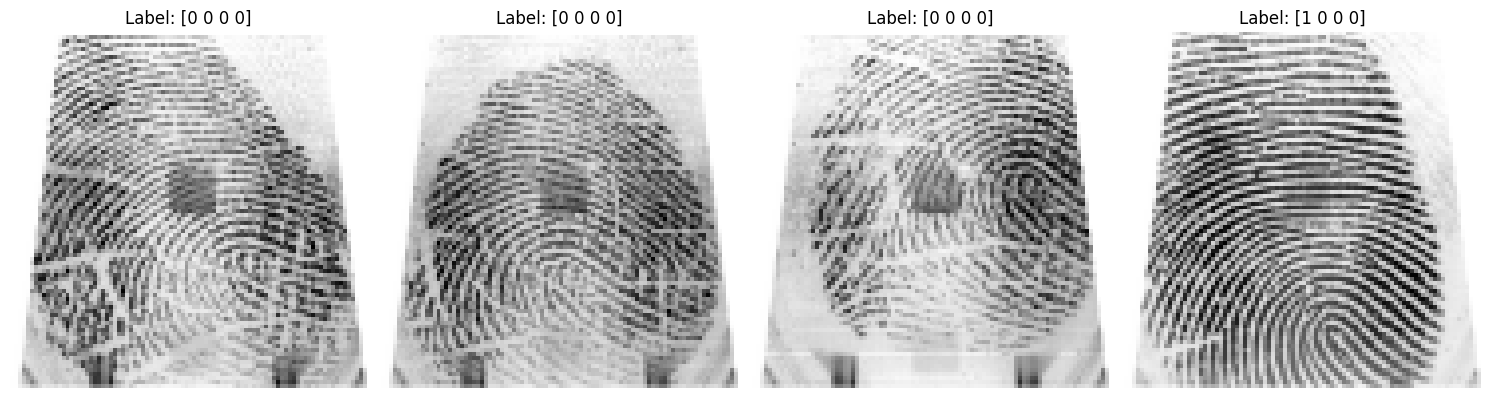

In [304]:
# ============================================
# Load Project-Data Dataset
# ============================================
import os
import glob

def apply_gabor_filter(img, target_size=(90, 90)):
    """
    Apply Gabor filter preprocessing to an image and resize to target size
    Parameters:
        img: Input image (grayscale, uint8)
        target_size: Target image size (height, width)
    Returns:
        Processed image (grayscale, uint8, resized to target_size)
    """
    import cv2
    
    # First resize to target size (more efficient and preserves more information)
    if len(img.shape) == 3:
        img_2d = img.squeeze()
    else:
        img_2d = img
    
    # Resize first to target size
    resized_img = cv2.resize(img_2d, (target_size[1], target_size[0]), interpolation=cv2.INTER_AREA)
    
    # Define the parameters for Gabor filtering (adjusted for smaller image size)
    ksize = (15, 15)  # Smaller kernel size for 90x90 images
    sigma = 3.0  # Reduced standard deviation
    theta = np.pi / 4  # Orientation of the Gabor filter (45 degrees)
    lambd = 5.0  # Reduced wavelength for smaller images
    gamma = 0.5  # Spatial aspect ratio
    psi = 0.0  # Phase offset
    
    # Create the Gabor filter
    gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    
    # Apply filter: filter2D(src, ddepth, kernel)
    # Convert to float32 for filtering, use -1 to keep same depth
    filtered_image = cv2.filter2D(resized_img.astype(np.float32), -1, gabor_kernel)
    
    # Normalize more conservatively - preserve relative intensity relationships
    # Use min-max normalization but keep the original intensity distribution
    filtered_min = filtered_image.min()
    filtered_max = filtered_image.max()
    
    if filtered_max > filtered_min:
        # Normalize to [0, 255] range
        filtered_image = ((filtered_image - filtered_min) / (filtered_max - filtered_min) * 255).astype(np.uint8)
    else:
        # If all values are the same, just convert to uint8
        filtered_image = resized_img.astype(np.uint8)
    
    return filtered_image

def load_project_data(data_dir='Project-Data', img_size=(90, 90), use_gabor_filter=True):
    """
    Load Project-Data dataset from .bmp files with optional Gabor filter preprocessing
    Parameters:
        data_dir: Dataset directory path
        img_size: Target image size (height, width) - default (90, 90)
        use_gabor_filter: Whether to apply Gabor filter preprocessing (default True)
    Returns:
        x_data: Image data array (N, 90, 90, 1) - uint8, [0, 255]
        y_data: Label data array (N, 4) - [subject_id(3), gender(1), left_right(1), finger(1)]
        file_paths: List of file paths corresponding to each image
    """
    import cv2
    
    # Define data directories
    train_dir = os.path.join(data_dir, 'train')
    validate_dir = os.path.join(data_dir, 'validate')
    test_dir = os.path.join(data_dir, 'test')
    
    # Collect all .bmp files
    train_files = sorted(glob.glob(os.path.join(train_dir, '*.bmp')))
    validate_files = sorted(glob.glob(os.path.join(validate_dir, '*.bmp')))
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp'))) if os.path.exists(test_dir) else []
    
    all_files = train_files + validate_files
    print(f"Found {len(all_files)} .bmp files (train: {len(train_files)}, validate: {len(validate_files)})")
    if test_files:
        print(f"Found {len(test_files)} test .bmp files (test directory exists)")
    
    # Store images, labels, and file paths
    images = []
    labels = []
    file_paths = []
    
    for file_path in all_files:
        try:
            # Read image from .bmp file (uint8, [0, 255])
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to read image {file_path}")
                continue
            
            # Apply preprocessing: resize to target size, optionally with Gabor filter
            if use_gabor_filter:
                img = apply_gabor_filter(img, target_size=img_size)
            else:
                # Just resize without Gabor filtering
                img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_AREA)
            
            # Add channel dimension (90, 90) -> (90, 90, 1)
            img = np.expand_dims(img, axis=-1)
            images.append(img)
            file_paths.append(file_path)  # Save file path
            
            # Parse label from filename
            # Filename format: ID_R0_number.bmp or similar
            filename = os.path.basename(file_path)
            filename_no_ext = filename.replace('.bmp', '')
            parts = filename_no_ext.split('_')
            
            if len(parts) >= 1:
                # Extract subject_id (from first part of filename)
                subject_id = int(parts[0])
                # For other information, use default values if not explicitly identified
                # Can be adjusted based on actual filename format
                gender = 0  # Default value, can be adjusted based on actual data
                left_right = 0  # Default value, can be adjusted based on actual data
                finger = 0  # Default value, can be adjusted based on actual data
                
                # If filename contains more information, can parse here
                # For example: if format is ID_Gender_LR_Finger_number
                if len(parts) >= 2:
                    # Can try to extract more information from filename
                    pass
                
                label = np.array([subject_id, gender, left_right, finger], dtype=np.int32)
                labels.append(label)
            else:
                print(f"Warning: Unable to parse filename {filename}")
        except Exception as e:
            print(f"Warning: Unable to load {file_path}: {str(e)}")
            continue
    
    # Convert to numpy arrays
    # Images are uint8 with values in [0, 255] from .bmp files
    x_data = np.array(images, dtype=np.uint8)
    y_data = np.array(labels, dtype=np.int32)
    
    print(f"Data shape: x_data={x_data.shape}, y_data={y_data.shape}")
    print(f"Image data type: {x_data.dtype}, pixel value range: [{x_data.min()}, {x_data.max()}]")
    return x_data, y_data, file_paths

# Load Project-Data dataset with optional Gabor filter preprocessing
# Note: Keep train and validate directories separated to avoid data leakage
# Set use_gabor_filter=False to disable Gabor filtering (only resize to 90x90)
USE_GABOR_FILTER = False  # Set to True to enable Gabor filtering, False to disable

x_data, label_data, file_paths = load_project_data('Project-Data', img_size=(90, 90), use_gabor_filter=USE_GABOR_FILTER)

# Method 1: Use train_test_split for random splitting (will mix together)
# x_train, x_val, label_train, label_val = train_test_split(
#     x_data, label_data, test_size=0.2, random_state=42
# )

# Method 2: Separate according to original directory structure (recommended, avoids data leakage)
# From the load_project_data function we know:
# - train_files has 1464 files
# - validate_files has 500 files
# According to loading order, first 1464 are training set, last 500 are validation set
num_train = 1464  # Can be seen from output
x_train = x_data[:num_train]
label_train = label_data[:num_train]
train_file_paths = file_paths[:num_train]  # Save training file paths
x_val = x_data[num_train:]
label_val = label_data[num_train:]
val_file_paths = file_paths[num_train:]  # Save validation file paths

# Load test set if it exists
x_test = None
label_test = None
test_file_paths = None
test_dir = os.path.join('Project-Data', 'test')
if os.path.exists(test_dir):
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp')))
    
    if test_files:
        test_images = []
        test_labels = []
        test_file_paths = []
        
        for file_path in test_files:
            try:
                # Read image from .bmp file (uint8, [0, 255])
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Unable to read test image {file_path}")
                    continue
                
                # Apply preprocessing: resize to target size, optionally with Gabor filter
                if USE_GABOR_FILTER:
                    img = apply_gabor_filter(img, target_size=(90, 90))
                else:
                    # Just resize without Gabor filtering
                    img = cv2.resize(img, (90, 90), interpolation=cv2.INTER_AREA)
                
                # Add channel dimension (90, 90) -> (90, 90, 1)
                img = np.expand_dims(img, axis=-1)
                test_images.append(img)
                test_file_paths.append(file_path)
                
                filename = os.path.basename(file_path)
                filename_no_ext = filename.replace('.bmp', '')
                parts = filename_no_ext.split('_')
                if len(parts) >= 1:
                    subject_id = int(parts[0])
                    label = np.array([subject_id, 0, 0, 0], dtype=np.int32)
                    test_labels.append(label)
            except Exception as e:
                print(f"Warning: Unable to load test file {file_path}: {str(e)}")
                continue
        
        x_test = np.array(test_images, dtype=np.uint8)
        label_test = np.array(test_labels, dtype=np.int32)
        print(f"\nTest set loaded: {x_test.shape}, {label_test.shape}")

print(f"\nTraining set: {x_train.shape}, {label_train.shape}")
print(f"Validation set: {x_val.shape}, {label_val.shape}")
if x_test is not None:
    print(f"Test set: {x_test.shape}, {label_test.shape}")
print(f"\n✓ Training and validation sets are separated to avoid data leakage")

# Print detailed data counts
print("\n" + "="*60)
print("Data Count Summary")
print("="*60)
print(f"Training set:")
print(f"  Number of images: {len(x_train)}")
print(f"  Number of labels: {len(label_train)}")
print(f"  Image shape: {x_train.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_train.shape[1:]} (4 values per label)")
print(f"\nValidation set:")
print(f"  Number of images: {len(x_val)}")
print(f"  Number of labels: {len(label_val)}")
print(f"  Image shape: {x_val.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_val.shape[1:]} (4 values per label)")
print(f"\nTotal dataset:")
print(f"  Total images: {len(x_data)}")
print(f"  Total labels: {len(label_data)}")
print("="*60)

# Display some sample images
plt.figure(figsize=(15, 5))
for i in range(min(4, len(x_train))):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f'Label: {label_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# diffrent techique appplied

In [305]:

print("Data information (already loaded and split in Cell 1):")
print(f"Total data: x_data={x_data.shape}, label_data={label_data.shape}")
print(f"Training set: x_train={x_train.shape}, label_train={label_train.shape}")
print(f"Validation set: x_val={x_val.shape}, label_val={label_val.shape}")

Data information (already loaded and split in Cell 1):
Total data: x_data=(1964, 90, 90, 1), label_data=(1964, 4)
Training set: x_train=(1464, 90, 90, 1), label_train=(1464, 4)
Validation set: x_val=(500, 90, 90, 1), label_val=(500, 4)


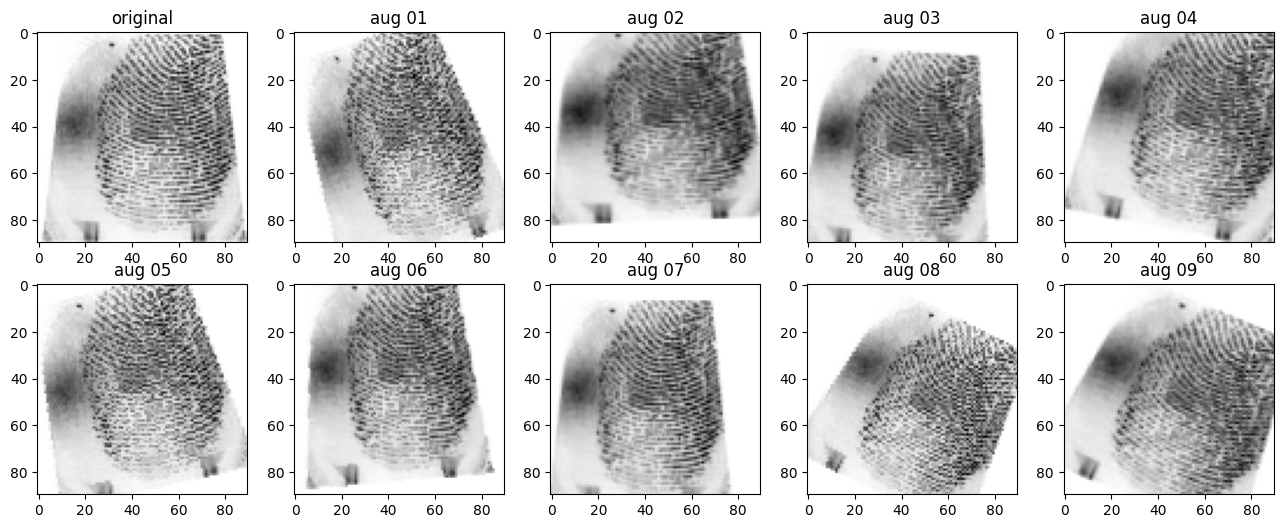

In [306]:
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
augs = [x_data[sample_idx]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
plt.imshow(x_data[sample_idx].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# enhacement

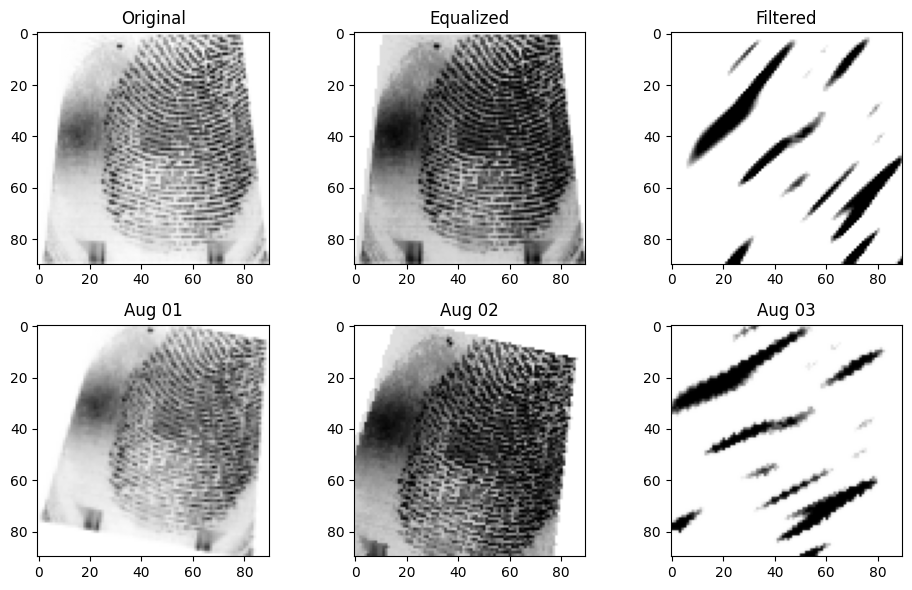

In [307]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Load the original image (use index that actually exists in dataset)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
original_image = x_data[sample_idx]

# Apply histogram equalization to enhance contrast
equalized_image = cv2.equalizeHist(original_image.squeeze())

# Define the parameters for Gabor filtering
ksize = (31, 31)  # Kernel size
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = np.pi / 4  # Orientation of the Gabor filter (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
psi = 0.0  # Phase offset

# Create the Gabor filter
gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

# Apply Gabor filtering
filtered_image = cv2.filter2D(original_image.squeeze(), cv2.CV_8UC3, gabor_kernel)

# Create augmentation sequence
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Blur images with a sigma of 0 to 0.5
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # Scale images to 90-110% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate by -10 to +10 percent (per axis)
        rotate=(-30, 30),  # Rotate by -30 to +30 degrees
        order=[0, 1],  # Use nearest neighbor or bilinear interpolation (fast)
        cval=255  # If mode is constant, use a cval between 0 and 255
    )
], random_order=True)

# Apply augmentation to the images
enhanced_augs = seq.augment_images([original_image, equalized_image, filtered_image])

# Plot the original and augmented images
plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Original')
plt.imshow(original_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 2)
plt.title('Equalized')
plt.imshow(equalized_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 3)
plt.title('Filtered')
plt.imshow(filtered_image.squeeze(), cmap='gray')

for i, aug in enumerate(enhanced_augs):
    plt.subplot(2, 5, i+6)
    plt.title('Aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()


In [308]:
# ============================================
# Create label_real_dict and x_real for Project-Data
# ============================================
# Important: x_real should only contain training set images to avoid data leakage
# This way, during training and validation, the model won't "see" validation set reference images
label_real_dict = {}
x_real_list = []
y_real_list = []
x_real_file_paths = []  # Store file paths for x_real images

# Use dictionary to track image index for each unique label
# key: label string, value: index in x_real
seen_labels = {}

# Create reference image set using only training set (avoid data leakage)
print("Creating reference image set (using only training set to avoid data leakage)...")
for i, label in enumerate(label_train):
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    
    if key not in seen_labels:
        # Save first image for each unique label as reference
        seen_labels[key] = len(x_real_list)
        label_real_dict[key] = len(x_real_list)
        x_real_list.append(x_train[i])
        y_real_list.append(label)
        x_real_file_paths.append(train_file_paths[i])  # Save corresponding file path
    else:
        # If already exists, update dictionary to point to existing index
        label_real_dict[key] = seen_labels[key]

# Convert to numpy arrays
x_real = np.array(x_real_list, dtype=np.uint8)
y_real = np.array(y_real_list, dtype=np.int32)

print(f"Reference image set (x_real): {x_real.shape}")
print(f"Reference label set (y_real): {y_real.shape}")
print(f"Number of unique labels: {len(seen_labels)}")
print(f"label_real_dict size: {len(label_real_dict)}")

# Verify: Check if all labels in training set are in dictionary
def check_labels_in_dict(labels, label_dict, name):
    """Check if all labels are in dictionary"""
    keys = set()
    for label in labels:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        keys.add(key)
    
    missing_keys = keys - set(label_dict.keys())
    if missing_keys:
        print(f"Warning: {name} has {len(missing_keys)} labels not in label_real_dict")
        print(f"Example missing keys: {list(missing_keys)[:5]}")
        return False, missing_keys
    else:
        print(f"✓ All labels in {name} are in label_real_dict")
        return True, set()

# Check training set (must all be in dictionary)
train_ok, train_missing = check_labels_in_dict(label_train, label_real_dict, "Training set")

# If there are missing labels, add them from training set
if train_missing:
    print(f"\nFound {len(train_missing)} missing labels, adding from training set...")
    for label in label_train:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        if key in train_missing and key not in label_real_dict:
            idx = np.where((label_train == label).all(axis=1))[0]
            if len(idx) > 0:
                label_real_dict[key] = len(x_real_list)
                x_real_list.append(x_train[idx[0]])
                y_real_list.append(label)
                x_real_file_paths.append(train_file_paths[idx[0]])  # Save file path
                train_missing.remove(key)
    
    # Update x_real and y_real
    x_real = np.array(x_real_list, dtype=np.uint8)
    y_real = np.array(y_real_list, dtype=np.int32)
    
    # Update file paths if needed (should already be updated in the loop above)
    print(f"Added missing labels, updated x_real shape: {x_real.shape}")
    print(f"Updated label_real_dict size: {len(label_real_dict)}")
    
    # Verify training set again
    train_ok, _ = check_labels_in_dict(label_train, label_real_dict, "Training set")

# Check validation set (validation set may have some new labels not in training set, this is normal)
val_keys = set()
for label in label_val:
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    val_keys.add(key)

val_missing = val_keys - set(label_real_dict.keys())
if val_missing:
    print(f"\nNote: Validation set has {len(val_missing)} labels not in training set")
    print(f"These will be handled using rejection mechanism (threshold-based) during inference")
    print(f"Example unknown labels: {list(val_missing)[:5]}")
else:
    print(f"\n✓ All labels in validation set are in training set (can evaluate completely)")

print("\n" + "="*60)
print("Training Strategy: Only Known Identities")
print("="*60)
print("✓ Model will only train on known identities (no UNKNOWN class)")
print("✓ Unknown fingerprints will be detected using rejection mechanism")
print("  (if similarity with all known identities < threshold, classify as UNKNOWN)")
print("="*60)

Creating reference image set (using only training set to avoid data leakage)...
Reference image set (x_real): (488, 90, 90, 1)
Reference label set (y_real): (488, 4)
Number of unique labels: 488
label_real_dict size: 488
✓ All labels in Training set are in label_real_dict

Note: Validation set has 12 labels not in training set
These will be handled using rejection mechanism (threshold-based) during inference
Example unknown labels: ['400000', '280000', '040000', '120000', '440000']

Training Strategy: Only Known Identities
✓ Model will only train on known identities (no UNKNOWN class)
✓ Unknown fingerprints will be detected using rejection mechanism
  (if similarity with all known identities < threshold, classify as UNKNOWN)


In [309]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True, **kwargs):
        'Initialization'
        super().__init__(**kwargs)  # Newer Keras versions require calling super().__init__()
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Only train on known identities (no UNKNOWN class)
        # Unknown fingerprints will be handled during inference using threshold-based rejection
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        # Get image shape dynamically from x (supports any image size)
        img_shape = self.x[0].shape  # e.g., (90, 90, 1)
        x2_batch = np.empty((self.batch_size,) + img_shape, dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # Data augmentation (applied on-the-fly during training)
        # Note: This is "online augmentation" - images are augmented differently each time
        # The dataset size remains the same (1464), but each epoch sees different variations
        # This effectively increases data diversity without expanding the dataset
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        # Only train on known identities - skip unknown fingerprints during training
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            # Only use known fingerprints for training
            # Skip unknown fingerprints (not in label_real_dict) - they will be handled during inference
            if match_key not in self.label_real_dict:
                # For unknown fingerprints, use a random known fingerprint as negative sample
                # This helps model learn to distinguish known from unknown
                unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.  # Negative sample: this is not a match
            else:
                # Known fingerprint: generate positive or negative sample
                if random.random() > 0.5:
                    # put matched image (positive sample: same fingerprint)
                    x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                    y_batch[i] = 1.
                else:
                    # put unmatched image (negative sample: different fingerprint)
                    while True:
                        unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                        if unmatch_key != match_key:
                            break
                    x2_batch[i] = self.x_real[unmatch_idx]
                    y_batch[i] = 0.

        # Ensure return format is tuple and data types are correct
        x1_batch = (x1_batch.astype(np.float32) / 255.)
        x2_batch = (x2_batch.astype(np.float32) / 255.)
        y_batch = y_batch.astype(np.float32)
        return (x1_batch, x2_batch), y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [310]:
# Create data generators
# Only train on known identities - unknown fingerprints will be handled during inference
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

print("="*60)
print("Data Generator Configuration (Threshold-based Rejection)")
print("="*60)
print("Training strategy:")
print("  - Known fingerprints: Compare with matching/non-matching known fingerprints")
print("  - Unknown fingerprints: Skipped during training (will use rejection mechanism in inference)")
print("  - Inference: If similarity with all known identities < threshold -> classify as UNKNOWN")
print("="*60)

Data Generator Configuration (Threshold-based Rejection)
Training strategy:
  - Known fingerprints: Compare with matching/non-matching known fingerprints
  - Unknown fingerprints: Skipped during training (will use rejection mechanism in inference)
  - Inference: If similarity with all known identities < threshold -> classify as UNKNOWN


In [311]:

# ============================================
# Modified Siamese Network: Distance-based with Contrastive Loss
# ============================================
# Architecture:
# - Shared CNN for feature extraction
# - L2 Normalization to maintain interpretable embedding space
# - Euclidean distance as output
# - Contrastive Loss as optimization objective

from keras import backend as K

def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    Contrastive loss function
    y_true: 1 for similar pairs, 0 for dissimilar pairs
    y_pred: Euclidean distance between embeddings
    """
    import tensorflow as tf
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Input layers
# Input shape: (90, 90, 1) - matches the preprocessed image size
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# Shared CNN for feature extraction
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Flatten()(feature)
feature = layers.Dense(128, activation='relu')(feature)

# L2 Normalization to maintain interpretable embedding space
# Need to specify output_shape for Lambda layer
def l2_normalize_layer(x):
    """
    L2 normalization: x / sqrt(sum(x^2))
    Manual implementation using TensorFlow operations for compatibility
    """
    import tensorflow as tf
    # Calculate L2 norm along axis=1
    # Use expand_dims to maintain shape for broadcasting (instead of keepdims)
    square_sum = tf.reduce_sum(tf.square(x), axis=1)
    l2_norm = tf.sqrt(square_sum + tf.keras.backend.epsilon())
    # Expand dims to match original shape for broadcasting
    l2_norm = tf.expand_dims(l2_norm, axis=1)
    # Normalize by dividing by L2 norm
    return x / l2_norm


feature = layers.Lambda(l2_normalize_layer, output_shape=lambda input_shape: input_shape)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)  # Embedding for input 1
x2_net = feature_model(x2)  # Embedding for input 2

# Calculate Euclidean distance between embeddings
# Distance = sqrt(sum((x1 - x2)^2))
def euclidean_distance_layer(inputs):
    import tensorflow as tf
    x1, x2 = inputs
    # Calculate squared difference
    diff_squared = tf.square(x1 - x2)
    # Sum along axis=1 and expand dims for shape (batch_size, 1)
    sum_squared = tf.reduce_sum(diff_squared, axis=1)
    sum_squared = tf.expand_dims(sum_squared, axis=1)
    # Take square root
    return tf.sqrt(sum_squared)

# Output shape function: for multiple inputs, receives list of shapes
# Both inputs have shape (batch_size, 128), output is (batch_size, 1)
def euclidean_output_shape(shapes):
    # shapes is a list: [shape1, shape2]
    # Both shapes are (batch_size, 128), output is (batch_size, 1)
    return (shapes[0][0], 1)

distance = layers.Lambda(euclidean_distance_layer, output_shape=euclidean_output_shape)([x1_net, x2_net])

# Model outputs Euclidean distance (smaller distance = more similar)
model = Model(inputs=[x1, x2], outputs=distance)

# Compile with contrastive loss
model.compile(
    loss=contrastive_loss,
    optimizer='adam',
    metrics=[]  # No accuracy metric for distance output
)

# Verify model input shape matches data shape
print("\n" + "="*70)
print("Model Input Shape Verification")
print("="*70)
print(f"Model input shape: {model.input_shape}")
print(f"Training data shape: {x_train.shape}")
print(f"Expected input shape: (None, {x_train.shape[1]}, {x_train.shape[2]}, {x_train.shape[3]})")
if model.input_shape[0][1:] == x_train.shape[1:]:
    print("✓ Model input shape matches data shape!")
else:
    print("✗ WARNING: Model input shape does NOT match data shape!")
    print("  Please re-run this cell to recreate the model with correct input shape.")
print("="*70)

print("="*60)
print("Modified Siamese Network Architecture")
print("="*60)
print("✓ Shared CNN for feature extraction")
print("✓ L2 Normalization to maintain interpretable embedding space")
print("✓ Euclidean distance as output (smaller = more similar)")
print("✓ Contrastive Loss as optimization objective")
print("="*60)
print()

model.summary()


Model Input Shape Verification
Model input shape: [(None, 90, 90, 1), (None, 90, 90, 1)]
Training data shape: (1464, 90, 90, 1)
Expected input shape: (None, 90, 90, 1)
✓ Model input shape matches data shape!
Modified Siamese Network Architecture
✓ Shared CNN for feature extraction
✓ L2 Normalization to maintain interpretable embedding space
✓ Euclidean distance as output (smaller = more similar)
✓ Contrastive Loss as optimization objective



Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_73      │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_44       │ (None, 128)       │  1,992,160 │ input_layer_72[0… │
│ (Functional)        │                   │            │ input_layer_73[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, 1)         │          0 │ functional_44[0]… │
│                     │                   │            │ functional_44[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,992,160 (7.60 MB)

 Trainable params: 1,992,160 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

In [313]:
history = model.fit(train_gen, epochs=100, validation_data=val_gen)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.3209 - val_loss: 0.2659
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2239 - val_loss: 0.2533
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2195 - val_loss: 0.2380
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2154 - val_loss: 0.2502
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2068 - val_loss: 0.2478
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1931 - val_loss: 0.2245
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1979 - val_loss: 0.2309
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1987 - val_loss: 0.2135
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1955 - val_loss: 0.2250
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1946 - val_loss: 0.2122
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1920 - val_loss: 0.2215
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

In [ ]:
# ============================================
# Evaluate Matching Accuracy on Validation Set
# ============================================
# Method: Manually calculate accuracy during validation phase
# 1. Get model output distance for each sample
# 2. Compare with ground truth label: same → 1, different → 0
# 3. Determine if distance < threshold matches label == 1 (same person)
# 4. Calculate accuracy, TPR, FPR, TNR, ROC, AUC and other metrics

import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

def evaluate_contrastive_predictions(model, x_val, label_val, x_real, label_real_dict, 
                                     threshold=None, num_pairs_per_sample=1):
    """
    Evaluate matching accuracy on validation set using threshold-based method
    
    Parameters:
        model: Trained Siamese model (outputs distance)
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        threshold: Distance threshold (if None, will be calculated from validation set)
        num_pairs_per_sample: Number of pairs to generate per validation sample
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    print("="*70)
    print("Evaluating Matching Accuracy on Validation Set")
    print("="*70)
    
    # Generate pairs: genuine (same person) and impostor (different person)
    y_true = []  # Ground truth: 1 for same person, 0 for different person
    y_pred = []  # Model predictions: distance values
    
    val_keys = []
    for label in label_val:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
    
    print("Generating genuine and impostor pairs...")
    genuine_count = 0
    impostor_count = 0
    
    # Generate genuine pairs (same person)
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            ref_idx = label_real_dict[test_key]
            ref_img = x_real[ref_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(1)  # Same person
            y_pred.append(distance)
            genuine_count += 1
    
    # Generate impostor pairs (different person)
    # For each validation sample, compare with a random different reference
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            # Find a different reference image
            while True:
                unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
                if unmatch_key != test_key:
                    break
            
            ref_img = x_real[unmatch_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(0)  # Different person
            y_pred.append(distance)
            impostor_count += 1
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)  # Distance values (smaller = more similar)
    
    print(f"\nGenerated pairs:")
    print(f"  Genuine pairs (same person): {genuine_count}")
    print(f"  Impostor pairs (different person): {impostor_count}")
    print(f"  Total pairs: {len(y_true)}")
    
    # Calculate optimal threshold if not provided
    if threshold is None:
        print("\nFinding optimal threshold...")
        # Use ROC curve to find optimal threshold (EER)
        fpr, tpr, thresholds_roc = roc_curve(y_true, -y_pred)  # Negative distance for ROC (larger = more similar)
        fnr = 1 - tpr
        eer_idx = np.nanargmin(np.abs(fpr - fnr))
        threshold = -thresholds_roc[eer_idx]  # Convert back to distance
        eer = fpr[eer_idx]
        print(f"  Optimal threshold (EER): {threshold:.4f}")
        print(f"  EER (Equal Error Rate): {eer:.4f}")
    else:
        print(f"\nUsing provided threshold: {threshold:.4f}")
    
    # Convert distance predictions to binary predictions
    # distance < threshold → same person (1), distance >= threshold → different person (0)
    y_pred_binary = (y_pred < threshold).astype(int)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_binary == y_true)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # True Positive Rate (sensitivity/recall)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate (specificity)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
    
    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Calculate ROC AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_true, -y_pred)  # Negative distance for ROC
    roc_auc = auc(fpr_roc, tpr_roc)
    
    print("\n" + "="*70)
    print("Evaluation Results:")
    print("="*70)
    print(f"Threshold: {threshold:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"  True Positives (TP): {tp}")
    print(f"\nMetrics:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  TPR (True Positive Rate / Sensitivity / Recall): {tpr:.4f}")
    print(f"  TNR (True Negative Rate / Specificity): {tnr:.4f}")
    print(f"  FPR (False Positive Rate): {fpr:.4f}")
    print(f"  FNR (False Negative Rate): {fnr:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("="*70)
    
    # Distance statistics
    genuine_distances = y_pred[y_true == 1]
    impostor_distances = y_pred[y_true == 0]
    
    print(f"\nDistance Statistics:")
    print(f"  Genuine pairs (same person):")
    print(f"    Mean: {np.mean(genuine_distances):.4f}")
    print(f"    Std: {np.std(genuine_distances):.4f}")
    print(f"    Min: {np.min(genuine_distances):.4f}")
    print(f"    Max: {np.max(genuine_distances):.4f}")
    print(f"  Impostor pairs (different person):")
    print(f"    Mean: {np.mean(impostor_distances):.4f}")
    print(f"    Std: {np.std(impostor_distances):.4f}")
    print(f"    Min: {np.min(impostor_distances):.4f}")
    print(f"    Max: {np.max(impostor_distances):.4f}")
    print("="*70)
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'tpr': tpr,
        'tnr': tnr,
        'fpr': fpr,
        'fnr': fnr,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'genuine_distances': genuine_distances,
        'impostor_distances': impostor_distances
    }

# Run evaluation
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals():
    print("Running validation set evaluation...")
    eval_results = evaluate_contrastive_predictions(
        model, x_val, label_val, x_real, label_real_dict,
        threshold=None  # Will calculate optimal threshold automatically
    )
    print(f"\n✓ Validation accuracy: {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)")
else:
    print("Please run the previous cells first to load data and train the model.")


Running validation set evaluation...
Evaluating Matching Accuracy on Validation Set
Generating genuine and impostor pairs...

Generated pairs:
  Genuine pairs (same person): 488
  Impostor pairs (different person): 488
  Total pairs: 976

Finding optimal threshold...
  Optimal threshold (EER): 0.5199
  EER (Equal Error Rate): 0.1865

Evaluation Results:
Threshold: 0.5199

Confusion Matrix:
  True Negatives (TN): 398
  False Positives (FP): 90
  False Negatives (FN): 92
  True Positives (TP): 396

Metrics:
  Accuracy: 0.8135 (81.35%)
  TPR (True Positive Rate / Sensitivity / Recall): 0.8115
  TNR (True Negative Rate / Specificity): 0.8156
  FPR (False Positive Rate): 0.1844
  FNR (False Negative Rate): 0.1885
  Precision: 0.8148
  F1-Score: 0.8131
  ROC AUC: 0.8938

Distance Statistics:
  Genuine pairs (same person):
    Mean: 0.3920
    Std: 0.1547
    Min: 0.0806
    Max: 1.0325
  Impostor pairs (different person):
    Mean: 0.7676
    Std: 0.2559
    Min: 0.1591
    Max: 1.3511

✓ Va

In [315]:
# ============================================
# Evaluate Matching Accuracy on Validation Set
# ============================================
# Method: Manually calculate accuracy during validation phase
# 1. Get model output distance for each sample
# 2. Compare with ground truth label: same → 1, different → 0
# 3. Determine if distance < threshold matches label == 1 (same person)
# 4. Calculate accuracy, TPR, FPR, TNR, ROC, AUC and other metrics

import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

def evaluate_contrastive_predictions(model, x_val, label_val, x_real, label_real_dict, 
                                     threshold=None, num_pairs_per_sample=1):
    """
    Evaluate matching accuracy on validation set using threshold-based method
    
    Parameters:
        model: Trained Siamese model (outputs distance)
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        threshold: Distance threshold (if None, will be calculated from validation set)
        num_pairs_per_sample: Number of pairs to generate per validation sample
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    print("="*70)
    print("Evaluating Matching Accuracy on Validation Set")
    print("="*70)
    
    # Generate pairs: genuine (same person) and impostor (different person)
    y_true = []  # Ground truth: 1 for same person, 0 for different person
    y_pred = []  # Model predictions: distance values
    
    val_keys = []
    for label in label_val:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
    
    print("Generating genuine and impostor pairs...")
    genuine_count = 0
    impostor_count = 0
    
    # Generate genuine pairs (same person)
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            ref_idx = label_real_dict[test_key]
            ref_img = x_real[ref_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(1)  # Same person
            y_pred.append(distance)
            genuine_count += 1
    
    # Generate impostor pairs (different person)
    # For each validation sample, compare with a random different reference
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            # Find a different reference image
            while True:
                unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
                if unmatch_key != test_key:
                    break
            
            ref_img = x_real[unmatch_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(0)  # Different person
            y_pred.append(distance)
            impostor_count += 1
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)  # Distance values (smaller = more similar)
    
    print(f"\nGenerated pairs:")
    print(f"  Genuine pairs (same person): {genuine_count}")
    print(f"  Impostor pairs (different person): {impostor_count}")
    print(f"  Total pairs: {len(y_true)}")
    
    # Calculate optimal threshold if not provided
    if threshold is None:
        print("\nFinding optimal threshold...")
        # Use ROC curve to find optimal threshold (EER)
        fpr, tpr, thresholds_roc = roc_curve(y_true, -y_pred)  # Negative distance for ROC (larger = more similar)
        fnr = 1 - tpr
        eer_idx = np.nanargmin(np.abs(fpr - fnr))
        threshold = -thresholds_roc[eer_idx]  # Convert back to distance
        eer = fpr[eer_idx]
        print(f"  Optimal threshold (EER): {threshold:.4f}")
        print(f"  EER (Equal Error Rate): {eer:.4f}")
    else:
        print(f"\nUsing provided threshold: {threshold:.4f}")
    
    # Convert distance predictions to binary predictions
    # distance < threshold → same person (1), distance >= threshold → different person (0)
    y_pred_binary = (y_pred < threshold).astype(int)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_binary == y_true)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # True Positive Rate (sensitivity/recall)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate (specificity)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
    
    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Calculate ROC AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_true, -y_pred)  # Negative distance for ROC
    roc_auc = auc(fpr_roc, tpr_roc)
    
    print("\n" + "="*70)
    print("Evaluation Results:")
    print("="*70)
    print(f"Threshold: {threshold:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"  True Positives (TP): {tp}")
    print(f"\nMetrics:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  TPR (True Positive Rate / Sensitivity / Recall): {tpr:.4f}")
    print(f"  TNR (True Negative Rate / Specificity): {tnr:.4f}")
    print(f"  FPR (False Positive Rate): {fpr:.4f}")
    print(f"  FNR (False Negative Rate): {fnr:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("="*70)
    
    # Distance statistics
    genuine_distances = y_pred[y_true == 1]
    impostor_distances = y_pred[y_true == 0]
    
    print(f"\nDistance Statistics:")
    print(f"  Genuine pairs (same person):")
    print(f"    Mean: {np.mean(genuine_distances):.4f}")
    print(f"    Std: {np.std(genuine_distances):.4f}")
    print(f"    Min: {np.min(genuine_distances):.4f}")
    print(f"    Max: {np.max(genuine_distances):.4f}")
    print(f"  Impostor pairs (different person):")
    print(f"    Mean: {np.mean(impostor_distances):.4f}")
    print(f"    Std: {np.std(impostor_distances):.4f}")
    print(f"    Min: {np.min(impostor_distances):.4f}")
    print(f"    Max: {np.max(impostor_distances):.4f}")
    print("="*70)
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'tpr': tpr,
        'tnr': tnr,
        'fpr': fpr,
        'fnr': fnr,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'genuine_distances': genuine_distances,
        'impostor_distances': impostor_distances
    }

# Run evaluation
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals():
    print("Running validation set evaluation...")
    eval_results = evaluate_contrastive_predictions(
        model, x_val, label_val, x_real, label_real_dict,
        threshold=None  # Will calculate optimal threshold automatically
    )
    print(f"\n✓ Validation accuracy: {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)")
else:
    print("Please run the previous cells first to load data and train the model.")


Running validation set evaluation...
Evaluating Matching Accuracy on Validation Set
Generating genuine and impostor pairs...

Generated pairs:
  Genuine pairs (same person): 488
  Impostor pairs (different person): 488
  Total pairs: 976

Finding optimal threshold...
  Optimal threshold (EER): 0.5294
  EER (Equal Error Rate): 0.1701

Evaluation Results:
Threshold: 0.5294

Confusion Matrix:
  True Negatives (TN): 406
  False Positives (FP): 82
  False Negatives (FN): 85
  True Positives (TP): 403

Metrics:
  Accuracy: 0.8289 (82.89%)
  TPR (True Positive Rate / Sensitivity / Recall): 0.8258
  TNR (True Negative Rate / Specificity): 0.8320
  FPR (False Positive Rate): 0.1680
  FNR (False Negative Rate): 0.1742
  Precision: 0.8309
  F1-Score: 0.8284
  ROC AUC: 0.9026

Distance Statistics:
  Genuine pairs (same person):
    Mean: 0.3920
    Std: 0.1547
    Min: 0.0806
    Max: 1.0325
  Impostor pairs (different person):
    Mean: 0.7718
    Std: 0.2396
    Min: 0.1425
    Max: 1.3480

✓ Va

Evaluating Matching Accuracy on Test Set (Verification Task)
Test set size: 500 samples
Using threshold from validation set: 0.5294
Evaluating Matching Accuracy on Validation Set
Generating genuine and impostor pairs...

Generated pairs:
  Genuine pairs (same person): 488
  Impostor pairs (different person): 488
  Total pairs: 976

Using provided threshold: 0.5294

Evaluation Results:
Threshold: 0.5294

Confusion Matrix:
  True Negatives (TN): 411
  False Positives (FP): 77
  False Negatives (FN): 142
  True Positives (TP): 346

Metrics:
  Accuracy: 0.7756 (77.56%)
  TPR (True Positive Rate / Sensitivity / Recall): 0.7090
  TNR (True Negative Rate / Specificity): 0.8422
  FPR (False Positive Rate): 0.1578
  FNR (False Negative Rate): 0.2910
  Precision: 0.8180
  F1-Score: 0.7596
  ROC AUC: 0.8752

Distance Statistics:
  Genuine pairs (same person):
    Mean: 0.4410
    Std: 0.1699
    Min: 0.0901
    Max: 0.9896
  Impostor pairs (different person):
    Mean: 0.7913
    Std: 0.2426
    

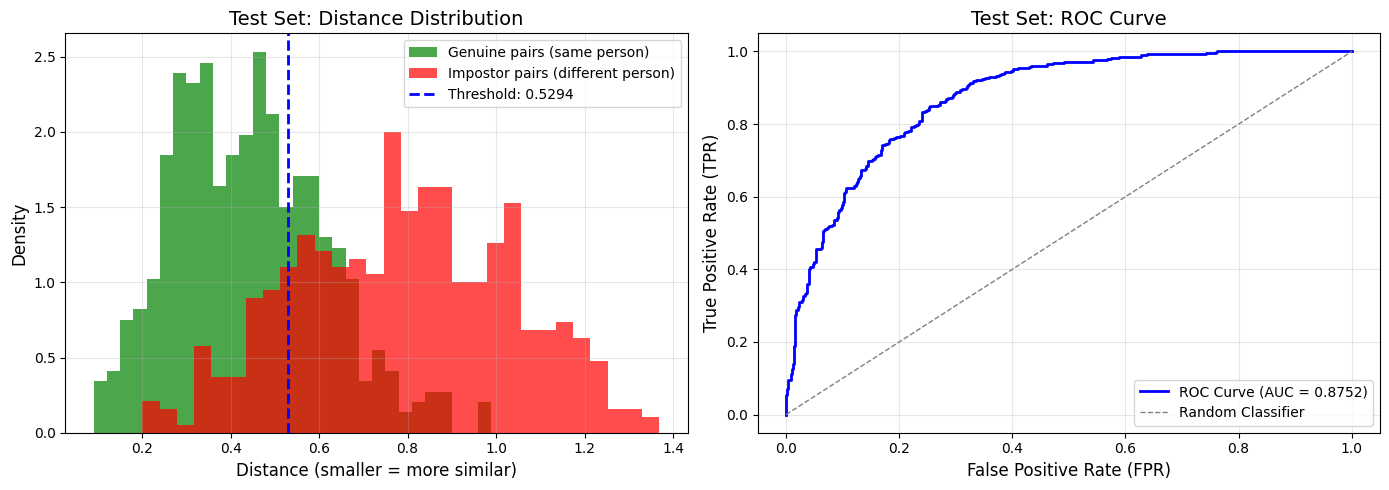


✓ Test set evaluation completed!


In [318]:
# ============================================
# Evaluate Matching Accuracy on Test Set (Verification Task)
# ============================================
# Use the same evaluation method as validation set
# This is a VERIFICATION task: given two images, determine if they are the same person
# Test set evaluation provides final performance metrics

if 'x_test' in globals() and x_test is not None and 'label_test' in globals() and label_test is not None:
    print("="*70)
    print("Evaluating Matching Accuracy on Test Set (Verification Task)")
    print("="*70)
    print(f"Test set size: {len(x_test)} samples")
    
    # Use the threshold from validation set evaluation if available
    if 'eval_results' in globals() and 'threshold' in eval_results:
        test_threshold = eval_results['threshold']
        print(f"Using threshold from validation set: {test_threshold:.4f}")
    else:
        test_threshold = None
        print("Will calculate optimal threshold from test set")
    
    # Run evaluation on test set (VERIFICATION task)
    test_eval_results = evaluate_contrastive_predictions(
        model, x_test, label_test, x_real, label_real_dict,
        threshold=test_threshold  # Use validation threshold or calculate new one
    )
    
    print("\n" + "="*70)
    print("Test Set Evaluation Summary (Verification Task)")
    print("="*70)
    print(f"Test Accuracy: {test_eval_results['accuracy']:.4f} ({test_eval_results['accuracy']*100:.2f}%)")
    print(f"Test TPR: {test_eval_results['tpr']:.4f}")
    print(f"Test TNR: {test_eval_results['tnr']:.4f}")
    print(f"Test FPR: {test_eval_results['fpr']:.4f}")
    print(f"Test FNR: {test_eval_results['fnr']:.4f}")
    print(f"Test Precision: {test_eval_results['precision']:.4f}")
    print(f"Test F1-Score: {test_eval_results['f1']:.4f}")
    print(f"Test ROC AUC: {test_eval_results['roc_auc']:.4f}")
    print("="*70)
    
    # Compare with validation set if available
    if 'eval_results' in globals():
        print("\n" + "="*70)
        print("Validation vs Test Set Comparison")
        print("="*70)
        print(f"{'Metric':<20} {'Validation':<15} {'Test':<15} {'Difference':<15}")
        print("-" * 70)
        print(f"{'Accuracy':<20} {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%){'':<5} {test_eval_results['accuracy']:.4f} ({test_eval_results['accuracy']*100:.2f}%){'':<5} {test_eval_results['accuracy'] - eval_results['accuracy']:+.4f}")
        print(f"{'TPR':<20} {eval_results['tpr']:.4f}{'':<15} {test_eval_results['tpr']:.4f}{'':<15} {test_eval_results['tpr'] - eval_results['tpr']:+.4f}")
        print(f"{'TNR':<20} {eval_results['tnr']:.4f}{'':<15} {test_eval_results['tnr']:.4f}{'':<15} {test_eval_results['tnr'] - eval_results['tnr']:+.4f}")
        print(f"{'ROC AUC':<20} {eval_results['roc_auc']:.4f}{'':<15} {test_eval_results['roc_auc']:.4f}{'':<15} {test_eval_results['roc_auc'] - eval_results['roc_auc']:+.4f}")
    print("="*70)
    
    # Visualization: Distance distribution comparison
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Distance distribution
    axes[0].hist(test_eval_results['genuine_distances'], bins=30, alpha=0.7, 
                label='Genuine pairs (same person)', color='green', density=True)
    axes[0].hist(test_eval_results['impostor_distances'], bins=30, alpha=0.7, 
                label='Impostor pairs (different person)', color='red', density=True)
    axes[0].axvline(test_eval_results['threshold'], color='blue', linestyle='--', linewidth=2, 
                    label=f'Threshold: {test_eval_results["threshold"]:.4f}')
    axes[0].set_xlabel('Distance (smaller = more similar)', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title('Test Set: Distance Distribution', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: ROC Curve
    fpr_roc, tpr_roc, _ = roc_curve(test_eval_results['y_true'], -test_eval_results['y_pred'])
    axes[1].plot(fpr_roc, tpr_roc, color='blue', linewidth=2, 
                label=f'ROC Curve (AUC = {test_eval_results["roc_auc"]:.4f})')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random Classifier')
    axes[1].set_xlabel('False Positive Rate (FPR)', fontsize=12)
    axes[1].set_ylabel('True Positive Rate (TPR)', fontsize=12)
    axes[1].set_title('Test Set: ROC Curve', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Test set evaluation completed!")
    
else:
    print("="*70)
    print("Test Set Not Available")
    print("="*70)
    print("Test set (x_test, label_test) is not loaded or is None.")
    print("Please run Cell 1 to load the test set first.")
    print("="*70)


In [232]:
# ============================================
# 配置优化器和学习率
# ============================================
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

# 方法1: 使用自定义学习率的Adam优化器
INITIAL_LEARNING_RATE = 0.001  # 初始学习率（默认Adam是0.001）
# 可以尝试不同的学习率：
# - 0.0001: 更小的学习率，训练更稳定但可能更慢
# - 0.001: 默认值，通常效果不错
# - 0.01: 更大的学习率，训练更快但可能不稳定

optimizer = Adam(
    learning_rate=INITIAL_LEARNING_RATE,  # 学习率
    beta_1=0.9,      # 一阶矩估计的指数衰减率（默认0.9）
    beta_2=0.999,    # 二阶矩估计的指数衰减率（默认0.999）
    epsilon=1e-07,   # 数值稳定性的小常数（默认1e-07）
    decay=0.0        # 学习率衰减率（可选，通常设为0）
)

# 方法2: 使用学习率调度回调函数（推荐）
# 当验证损失停止改善时自动降低学习率
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # 监控验证损失
    factor=0.5,              # 学习率降低因子（新学习率 = 旧学习率 * factor）
    patience=5,              # 等待多少个epoch没有改善后降低学习率
    min_lr=1e-7,            # 学习率的下限
    verbose=1                # 是否打印学习率变化信息
)

# 方法3: 自定义学习率调度函数（可选）
def lr_schedule(epoch):
    """
    自定义学习率调度函数
    可以根据epoch动态调整学习率
    """
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.5  # 10个epoch后减半
    elif epoch < 30:
        return initial_lr * 0.25  # 20个epoch后再减半
    else:
        return initial_lr * 0.1   # 30个epoch后降到0.1倍

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# 重新编译模型（使用自定义优化器）
# 注意：如果已经编译过，需要重新编译才能应用新的优化器设置
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer,  # 使用自定义优化器
    metrics=['acc']
)

print("="*60)
print("优化器配置:")
print("="*60)
print(f"优化器: Adam")
print(f"初始学习率: {INITIAL_LEARNING_RATE}")
print(f"Beta 1: 0.9")
print(f"Beta 2: 0.999")
print(f"Epsilon: 1e-07")
print("\n学习率调度选项:")
print("1. ReduceLROnPlateau: 当验证损失5个epoch不改善时，学习率减半")
print("2. LearningRateScheduler: 根据epoch自定义学习率变化")
print("\n使用方法:")
print("history = model.fit(")
print("    train_gen,")
print("    epochs=60,")
print("    validation_data=val_gen,")
print("    callbacks=[reduce_lr]  # 或 callbacks=[lr_scheduler]")
print(")")
print("="*60)


优化器配置:
优化器: Adam
初始学习率: 0.001
Beta 1: 0.9
Beta 2: 0.999
Epsilon: 1e-07

学习率调度选项:
1. ReduceLROnPlateau: 当验证损失5个epoch不改善时，学习率减半
2. LearningRateScheduler: 根据epoch自定义学习率变化

使用方法:
history = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=[reduce_lr]  # 或 callbacks=[lr_scheduler]
)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Pair Verification Result
Test sample index: 259
Test key: 259000
Reference key: 259000
Ground truth: Same Person (Genuine)
Distance: 0.4923
Threshold: 0.5446
Prediction: MATCH
Correct: ✓ YES


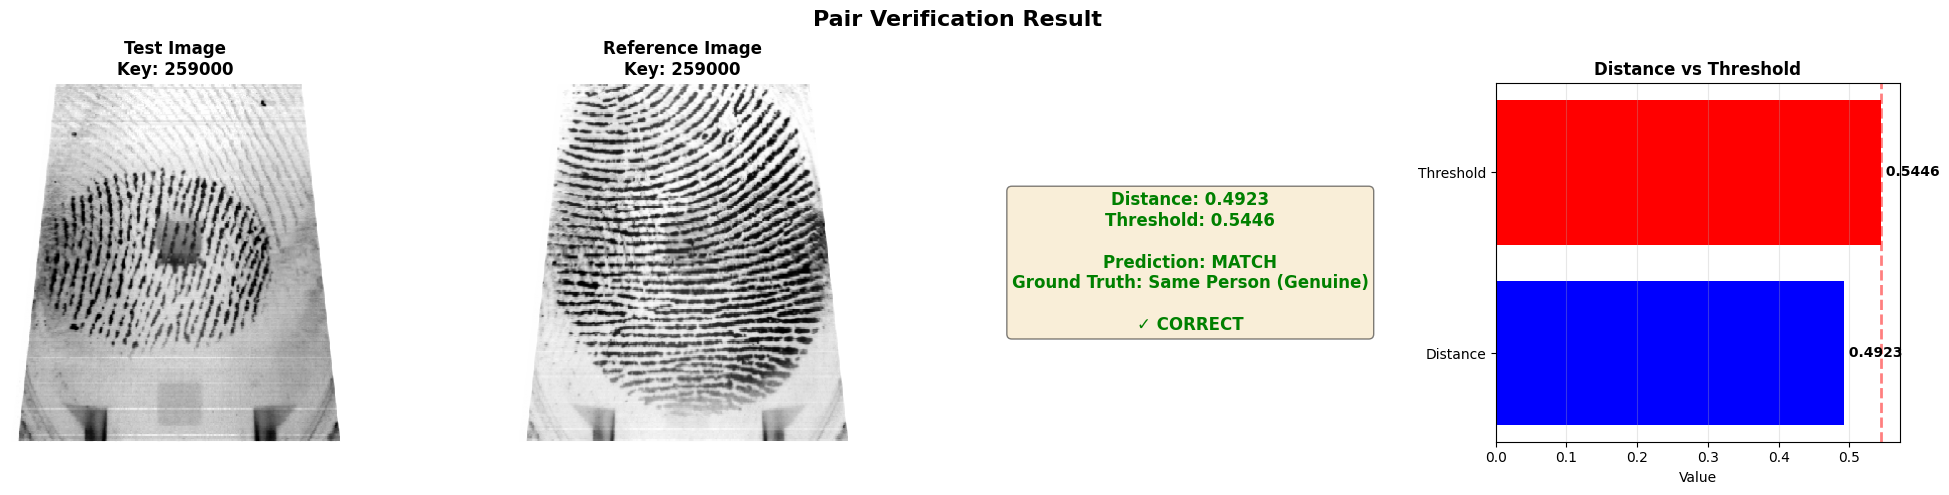


Summary:
✓ SUCCESS: Correctly verified!
  Correctly identified as SAME PERSON (genuine pair)


In [ ]:
# ============================================
# Visualize IDENTIFICATION Result from Test Set
# ============================================
# Select one test sample and identify which identity it belongs to
# This is an IDENTIFICATION task: given one image, find the best matching identity from all known identities

import numpy as np
import matplotlib.pyplot as plt
import random

# Check prerequisites
if 'x_test' not in globals() or x_test is None:
    print("Error: Test set not loaded. Please run the data loading cell first.")
elif 'model' not in globals():
    print("Error: Model not trained. Please train the model first.")
elif 'x_real' not in globals() or 'label_real_dict' not in globals():
    print("Error: Reference images not created. Please run the reference image creation cell first.")
else:
    # Select a random test sample
    test_idx = random.randint(0, len(x_test) - 1)
    test_img = x_test[test_idx]
    test_label = label_test[test_idx]
    
    # Convert test label to key format
    test_key = ''.join(test_label.astype(str)).zfill(6)
    
    print("="*70)
    print("IDENTIFICATION Result")
    print("="*70)
    print(f"Test sample index: {test_idx}")
    print(f"Test key (ground truth): {test_key}")
    print(f"Is test key in known identities: {test_key in label_real_dict}")
    print("="*70)
    
    # Prepare test image for prediction
    test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
    
    # Calculate distance to all reference images
    print("\nCalculating distances to all reference images...")
    distances = {}
    for ref_key, ref_idx in label_real_dict.items():
        ref_img = x_real[ref_idx]
        ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
        distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
        distances[ref_key] = distance
    
    # Sort by distance (smaller = more similar)
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    
    # Get the best match (smallest distance)
    best_match_key, best_distance = sorted_distances[0]
    best_match_idx = label_real_dict[best_match_key]
    best_match_img = x_real[best_match_idx]
    
    # Check if the best match is correct
    is_correct = (best_match_key == test_key)
    
    # Get distance to correct match (if test_key is known)
    correct_distance = None
    correct_rank = None
    if test_key in label_real_dict:
        correct_distance = distances[test_key]
        # Find rank of correct match
        for rank, (key, dist) in enumerate(sorted_distances, 1):
            if key == test_key:
                correct_rank = rank
                break
    
    # Print results
    print(f"\n{'='*70}")
    print("Identification Results:")
    print("="*70)
    print(f"Best match (smallest distance): {best_match_key}")
    print(f"Best match distance: {best_distance:.4f}")
    print(f"Ground truth: {test_key}")
    print(f"Match is correct: {is_correct}")
    
    if test_key in label_real_dict:
        print(f"\nCorrect match information:")
        print(f"  Distance to correct match: {correct_distance:.4f}")
        print(f"  Rank of correct match: {correct_rank} / {len(sorted_distances)}")
        if correct_rank > 1:
            print(f"  Difference from best match: {abs(correct_distance - best_distance):.4f}")
    
    # Show top 10 matches
    print(f"\nTop 10 Matches:")
    for i, (match_key, dist) in enumerate(sorted_distances[:10], 1):
        marker = " ← CORRECT" if match_key == test_key else ""
        print(f"  {i:2d}. {match_key}: distance = {dist:.4f}{marker}")
    
    # Visualization - Use 1x4 layout
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('IDENTIFICATION Result', fontsize=16, fontweight='bold')
    
    # Test image
    axes[0].imshow(test_img.squeeze(), cmap='gray')
    axes[0].set_title(f'Test Image\nGround Truth: {test_key}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Best match image
    axes[1].imshow(best_match_img.squeeze(), cmap='gray')
    status = "✓ CORRECT" if is_correct else "✗ INCORRECT"
    color = 'green' if is_correct else 'red'
    axes[1].set_title(f'Best Match: {best_match_key}\nDistance: {best_distance:.4f}\n{status}', 
                     fontsize=12, fontweight='bold', color=color)
    axes[1].axis('off')
    
    # Result panel (text information)
    axes[2].axis('off')
    result_text = f"Best Match: {best_match_key}\n"
    result_text += f"Distance: {best_distance:.4f}\n"
    result_text += f"\nGround Truth: {test_key}\n"
    result_text += f"\n{'✓ CORRECT' if is_correct else '✗ INCORRECT'}"
    
    if test_key in label_real_dict:
        result_text += f"\n\nCorrect Match:\n"
        result_text += f"  Distance: {correct_distance:.4f}\n"
        result_text += f"  Rank: {correct_rank}/{len(sorted_distances)}"
    
    text_color = 'green' if is_correct else 'red'
    axes[2].text(0.5, 0.5, result_text, 
                fontsize=11, fontweight='bold', color=text_color,
                ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                transform=axes[2].transAxes)
    
    # Top 10 matches distance chart
    top_n = 10
    top_matches = sorted_distances[:top_n]
    colors_list = ['green' if k == test_key else 'blue' for k, _ in top_matches]
    bars = axes[3].barh(range(len(top_matches)), [d for _, d in top_matches], color=colors_list)
    axes[3].set_yticks(range(len(top_matches)))
    axes[3].set_yticklabels([k for k, _ in top_matches], fontsize=8)
    axes[3].set_xlabel('Distance', fontsize=10)
    axes[3].set_title(f'Top {top_n} Matches Distance', fontsize=12, fontweight='bold')
    axes[3].invert_yaxis()
    axes[3].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, (key, dist)) in enumerate(zip(bars, top_matches)):
        axes[3].text(dist, i, f' {dist:.4f}', va='center', fontsize=8, fontweight='bold')
    
    # Add vertical line for correct match if known
    if test_key in label_real_dict and correct_rank <= top_n:
        axes[3].axvline(x=correct_distance, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Correct match')
        axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Final summary
    print("\n" + "="*70)
    print("Summary:")
    print("="*70)
    if is_correct:
        print("✓ SUCCESS: Correctly identified!")
        print(f"  Test sample {test_key} was correctly matched to {best_match_key}")
    else:
        print("✗ FAILED: Incorrectly identified")
        print(f"  Test sample {test_key} was matched to {best_match_key} instead")
        if test_key in label_real_dict:
            print(f"  Correct match distance: {correct_distance:.4f} (rank {correct_rank})")
            print(f"  Best match distance: {best_distance:.4f} (rank 1)")
    print("="*70)



Using threshold from validation set: 0.5446
Finding Unknown Identities in Test Set
Total test samples: 500
Unknown identities found: 12
Known identities: 488

Unknown identity keys: ['040000', '080000', '120000', '160000', '200000', '240000', '280000', '320000', '360000', '400000']...

Processing unknown samples...
  Processed 10/12 unknown samples...

Unknown Identity Detection Results
Total unknown samples: 12
Correctly rejected (min_distance >= threshold): 0
Incorrectly accepted (min_distance < threshold): 12
Rejection Rate: 0.0000 (0.00%)
Threshold: 0.5446

Minimum Distance Statistics for Unknown Samples:
  Mean: 0.1880
  Std: 0.0474
  Min: 0.1177
  Max: 0.2644
  Median: 0.2103

Visualizing examples of unknown identity detection...


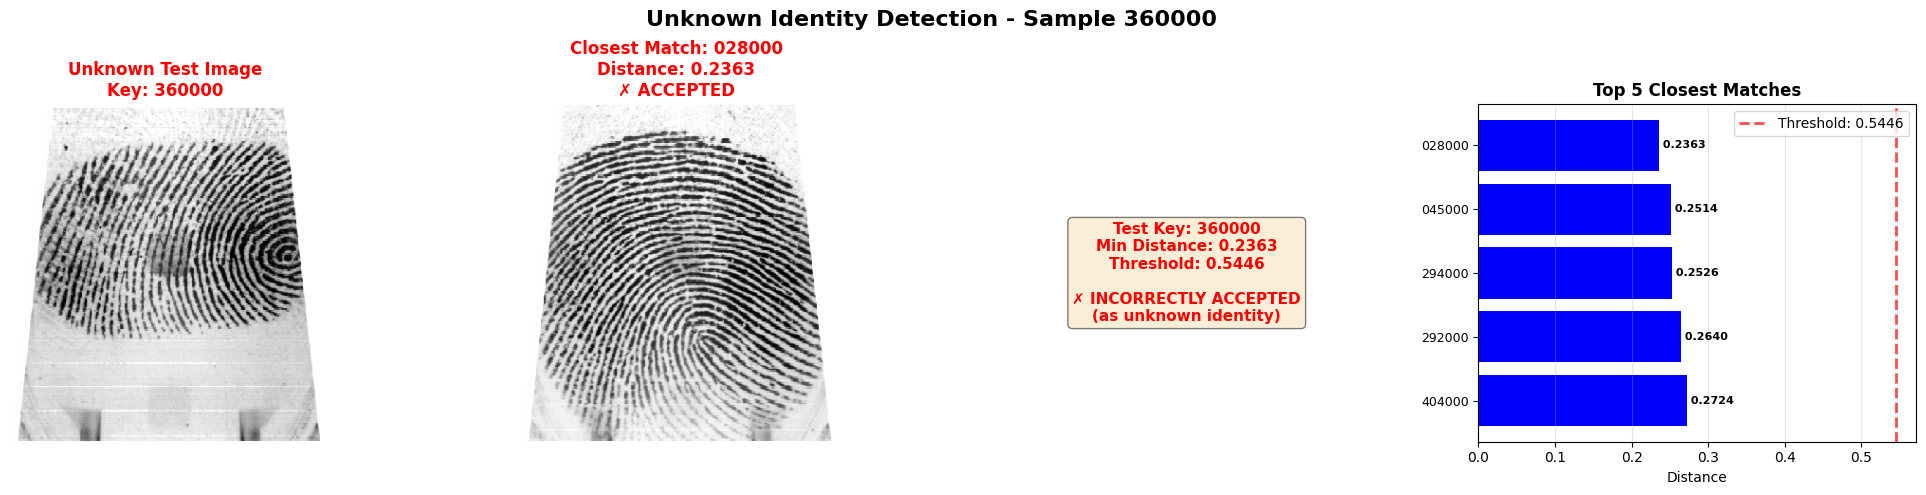


Example 9:
  Test key: 360000
  Minimum distance: 0.2363
  Closest match: 028000
  Threshold: 0.5446
  Status: ✗ INCORRECTLY ACCEPTED


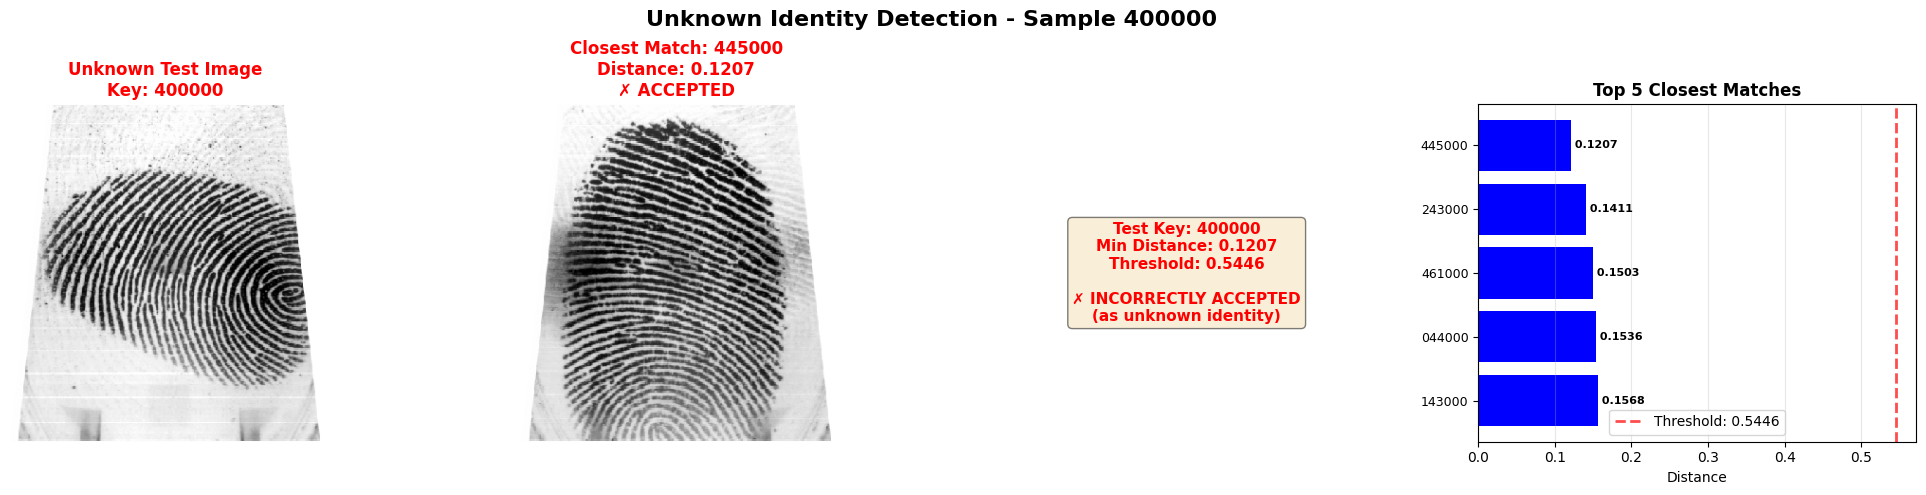


Example 10:
  Test key: 400000
  Minimum distance: 0.1207
  Closest match: 445000
  Threshold: 0.5446
  Status: ✗ INCORRECTLY ACCEPTED


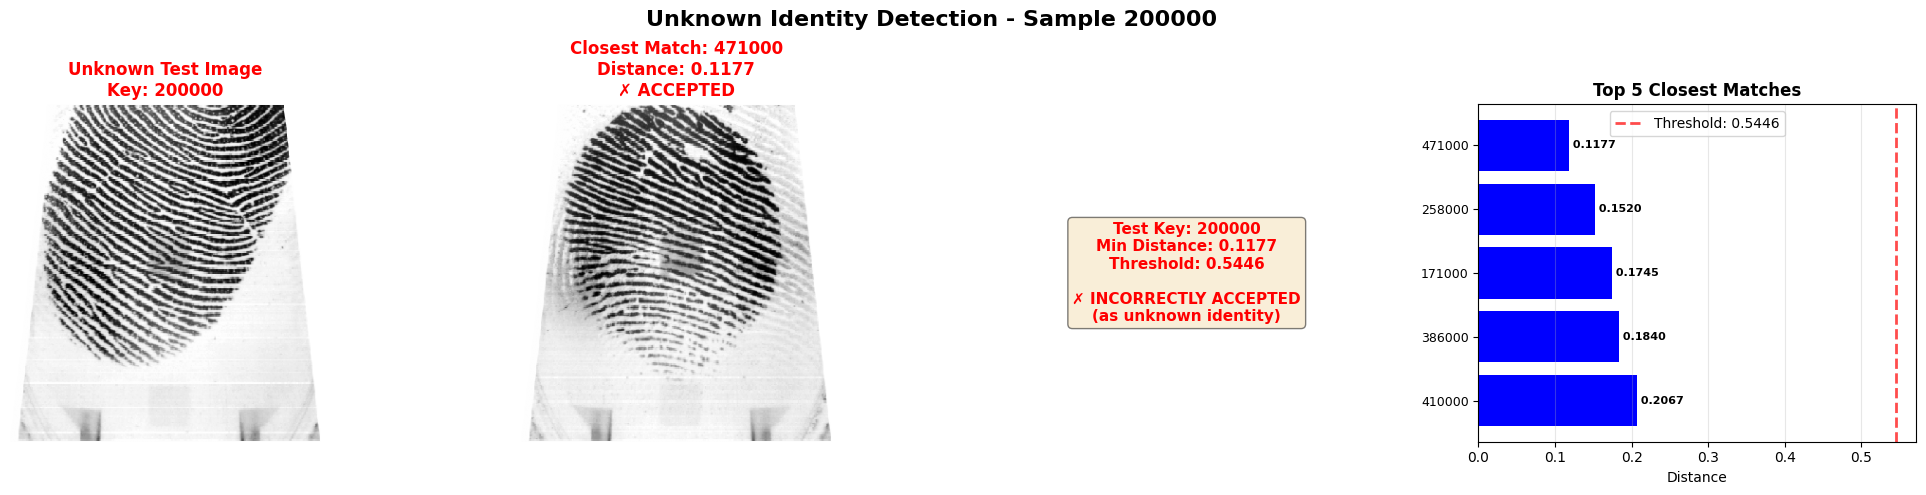


Example 5:
  Test key: 200000
  Minimum distance: 0.1177
  Closest match: 471000
  Threshold: 0.5446
  Status: ✗ INCORRECTLY ACCEPTED

Summary:
Out of 12 unknown samples:
  0 were correctly rejected (identified as unknown)
  12 were incorrectly accepted (matched to known identity)
  Rejection accuracy: 0.0000 (0.00%)


In [272]:
# ============================================
# Detect Unknown Identities in Test Set (Open-Set Recognition)
# ============================================
# Find all unknown data points in test set (not in label_real_dict)
# For each unknown sample, compare with all reference images
# Check if we can identify it as "new" (all distances >= threshold)

import numpy as np
import matplotlib.pyplot as plt
import random

# Check prerequisites
if 'x_test' not in globals() or x_test is None:
    print("Error: Test set not loaded. Please run the data loading cell first.")
elif 'model' not in globals():
    print("Error: Model not trained. Please train the model first.")
elif 'x_real' not in globals() or 'label_real_dict' not in globals():
    print("Error: Reference images not created. Please run the reference image creation cell first.")
else:
    # Get threshold from validation evaluation if available
    threshold = None
    if 'eval_results' in globals() and 'threshold' in eval_results:
        threshold = eval_results['threshold']
        print(f"Using threshold from validation set: {threshold:.4f}")
    else:
        print("Warning: Threshold not available. Please run validation evaluation first.")
        print("Will proceed without threshold-based rejection.")
    
    # Find all unknown identities in test set
    print("="*70)
    print("Finding Unknown Identities in Test Set")
    print("="*70)
    
    unknown_indices = []
    unknown_keys = []
    
    for i in range(len(x_test)):
        test_label = label_test[i]
        test_key = ''.join(test_label.astype(str)).zfill(6)
        if test_key not in label_real_dict:
            unknown_indices.append(i)
            unknown_keys.append(test_key)
    
    print(f"Total test samples: {len(x_test)}")
    print(f"Unknown identities found: {len(unknown_indices)}")
    print(f"Known identities: {len(x_test) - len(unknown_indices)}")
    
    if len(unknown_indices) == 0:
        print("\nNo unknown identities found in test set!")
        print("All test samples are in the training set.")
    else:
        print(f"\nUnknown identity keys: {unknown_keys[:10]}{'...' if len(unknown_keys) > 10 else ''}")
        print("="*70)
        
        # Process all unknown samples
        print("\nProcessing unknown samples...")
        results = []
        
        for idx, test_idx in enumerate(unknown_indices):
            test_img = x_test[test_idx]
            test_label = label_test[test_idx]
            test_key = unknown_keys[idx]
            
            # Prepare test image
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            
            # Calculate distance to all reference images
            distances = {}
            min_distance = float('inf')
            min_distance_key = None
            
            for ref_key, ref_idx in label_real_dict.items():
                ref_img = x_real[ref_idx]
                ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
                distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
                distances[ref_key] = distance
                
                if distance < min_distance:
                    min_distance = distance
                    min_distance_key = ref_key
            
            # Check if it can be identified as "new" (unknown)
            # If minimum distance >= threshold, it's correctly rejected as unknown
            if threshold is not None:
                is_correctly_rejected = (min_distance >= threshold)
            else:
                is_correctly_rejected = None
            
            results.append({
                'test_idx': test_idx,
                'test_key': test_key,
                'min_distance': min_distance,
                'min_distance_key': min_distance_key,
                'is_correctly_rejected': is_correctly_rejected,
                'distances': distances
            })
            
            if (idx + 1) % 10 == 0:
                print(f"  Processed {idx + 1}/{len(unknown_indices)} unknown samples...")
        
        # Calculate statistics
        if threshold is not None:
            correctly_rejected = sum(1 for r in results if r['is_correctly_rejected'])
            incorrectly_accepted = len(results) - correctly_rejected
            rejection_rate = correctly_rejected / len(results) if len(results) > 0 else 0.0
            
            print("\n" + "="*70)
            print("Unknown Identity Detection Results")
            print("="*70)
            print(f"Total unknown samples: {len(results)}")
            print(f"Correctly rejected (min_distance >= threshold): {correctly_rejected}")
            print(f"Incorrectly accepted (min_distance < threshold): {incorrectly_accepted}")
            print(f"Rejection Rate: {rejection_rate:.4f} ({rejection_rate*100:.2f}%)")
            print(f"Threshold: {threshold:.4f}")
            print("="*70)
            
            # Distance statistics
            min_distances = [r['min_distance'] for r in results]
            print(f"\nMinimum Distance Statistics for Unknown Samples:")
            print(f"  Mean: {np.mean(min_distances):.4f}")
            print(f"  Std: {np.std(min_distances):.4f}")
            print(f"  Min: {np.min(min_distances):.4f}")
            print(f"  Max: {np.max(min_distances):.4f}")
            print(f"  Median: {np.median(min_distances):.4f}")
            print("="*70)
        
        # Visualize a few examples
        print("\nVisualizing examples of unknown identity detection...")
        
        # Select a few examples to visualize
        num_examples = min(3, len(results))
        example_indices = random.sample(range(len(results)), num_examples)
        
        for example_idx in example_indices:
            result = results[example_idx]
            test_idx = result['test_idx']
            test_key = result['test_key']
            min_distance = result['min_distance']
            min_distance_key = result['min_distance_key']
            is_correctly_rejected = result['is_correctly_rejected']
            
            test_img = x_test[test_idx]
            min_distance_ref_idx = label_real_dict[min_distance_key]
            min_distance_ref_img = x_real[min_distance_ref_idx]
            
            # Get top 5 closest matches
            sorted_distances = sorted(result['distances'].items(), key=lambda x: x[1])[:5]
            
            # Visualization
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            fig.suptitle(f'Unknown Identity Detection - Sample {test_key}', fontsize=16, fontweight='bold')
            
            # Test image (unknown)
            axes[0].imshow(test_img.squeeze(), cmap='gray')
            axes[0].set_title(f'Unknown Test Image\nKey: {test_key}', fontsize=12, fontweight='bold', color='red')
            axes[0].axis('off')
            
            # Closest match
            axes[1].imshow(min_distance_ref_img.squeeze(), cmap='gray')
            status = "✓ REJECTED" if (is_correctly_rejected if threshold is not None else None) else "✗ ACCEPTED" if threshold is not None else "N/A"
            color = 'green' if (is_correctly_rejected if threshold is not None else None) else 'red' if threshold is not None else 'black'
            axes[1].set_title(f'Closest Match: {min_distance_key}\nDistance: {min_distance:.4f}\n{status}', 
                             fontsize=12, fontweight='bold', color=color)
            axes[1].axis('off')
            
            # Result panel
            axes[2].axis('off')
            result_text = f"Test Key: {test_key}\n"
            result_text += f"Min Distance: {min_distance:.4f}\n"
            if threshold is not None:
                result_text += f"Threshold: {threshold:.4f}\n"
                result_text += f"\n{'✓ CORRECTLY REJECTED' if is_correctly_rejected else '✗ INCORRECTLY ACCEPTED'}\n"
                result_text += f"(as unknown identity)"
                text_color = 'green' if is_correctly_rejected else 'red'
            else:
                result_text += "\n(Threshold not available)"
                text_color = 'black'
            
            axes[2].text(0.5, 0.5, result_text, 
                        fontsize=11, fontweight='bold', color=text_color,
                        ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                        transform=axes[2].transAxes)
            
            # Top 5 matches distance chart
            top_matches = sorted_distances
            colors_list = ['blue'] * len(top_matches)
            bars = axes[3].barh(range(len(top_matches)), [d for _, d in top_matches], color=colors_list)
            axes[3].set_yticks(range(len(top_matches)))
            axes[3].set_yticklabels([k for k, _ in top_matches], fontsize=9)
            axes[3].set_xlabel('Distance', fontsize=10)
            axes[3].set_title(f'Top 5 Closest Matches', fontsize=12, fontweight='bold')
            axes[3].invert_yaxis()
            axes[3].grid(axis='x', alpha=0.3)
            
            # Add value labels on bars
            for i, (bar, (key, dist)) in enumerate(zip(bars, top_matches)):
                axes[3].text(dist, i, f' {dist:.4f}', va='center', fontsize=8, fontweight='bold')
            
            # Add threshold line if available
            if threshold is not None:
                axes[3].axvline(x=threshold, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'Threshold: {threshold:.4f}')
                axes[3].legend()
            
            plt.tight_layout()
            plt.show()
            
            # Print summary for this example
            print(f"\nExample {example_idx + 1}:")
            print(f"  Test key: {test_key}")
            print(f"  Minimum distance: {min_distance:.4f}")
            print(f"  Closest match: {min_distance_key}")
            if threshold is not None:
                print(f"  Threshold: {threshold:.4f}")
                print(f"  Status: {'✓ CORRECTLY REJECTED' if is_correctly_rejected else '✗ INCORRECTLY ACCEPTED'}")
        
        print("\n" + "="*70)
        print("Summary:")
        print("="*70)
        if threshold is not None:
            print(f"Out of {len(results)} unknown samples:")
            print(f"  {correctly_rejected} were correctly rejected (identified as unknown)")
            print(f"  {incorrectly_accepted} were incorrectly accepted (matched to known identity)")
            print(f"  Rejection accuracy: {rejection_rate:.4f} ({rejection_rate*100:.2f}%)")
        else:
            print("Threshold not available - cannot determine rejection accuracy")
        print("="*70)

